In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import polars as pl

from joblib import Parallel, delayed
from pathlib import Path
from functools import partial
from copy import copy
from typing import List
from time import perf_counter
from collections import deque, namedtuple

In [3]:
from environments.easy21 import (
    EasyAction, 
    EasyState, 
    EasyEnvironment,
    DealerAgent, 
    EasyAgent,
    MCAgent, 
    TDAgent,
    EpsilonGreedyPolicy
)

from environments.base import Transition
from environments.utils import StateActionPair, CountRegistry, ValueRegistry

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

%matplotlib inline

In [5]:
def plot_value_function(df_V, title="Value function", ax = None):

    if ax is None:
        fig = plt.figure(figsize=(15, 8))
        ax = fig.add_subplot(111, projection='3d')
        
    ax.set_xlabel("Dealer showing")
    ax.set_ylabel("Player sum")
    ax.set_zlim([-1, 1])
    
    # Set title
    title = ax.text(2, 21, 1.3, title)
    
    # Prepare X and Y dimensions
    x_linspace = df_V["Dealer showing"]
    y_linspace = np.array(df_V.columns[1:], dtype=int)
    x, y = np.meshgrid(x_linspace, y_linspace)
    z = df_V[:, 1:].to_numpy().transpose()
    
    # Plot the surface.
    surf = ax.plot_surface(x, y, z, 
                           cmap=cm.coolwarm,
                           rstride=1, cstride=1,
                           linewidth=0, antialiased=False)
    
    return surf, title


def animate(checkpoints, name):
    
    # Adjusted from https://github.com/hereismari/easy21/blob/master/easy21.ipynb
    
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    def plot_frame(idx):
        
        checkpoint = checkpoints[idx]
        
        ax.clear()
        surf, title = plot_value_function(
            df_V=checkpoint.V,
            ax=ax
        )
        title.set_text(f"Frame: {idx} - i: {checkpoint.i} - mean reward: {checkpoint.mean_reward}")
        fig.canvas.draw()
        return surf
    
    ani = animation.FuncAnimation(fig, plot_frame, len(checkpoints), repeat=False, blit=False)
    
    # Prepare path 
    p = Path().cwd().parent / "animations"
    p.mkdir(exist_ok=True)
    p = p / f"{name}.gif"
    
    # Save animation
    ani.save(p, writer='imagemagick', fps=3)
    
    plt.show()


def print_progress(i, n, time_elapsed, mean_reward):
    print(
        f"Episode: {i:>10}/{n} "
        + f"--- {i/n*100:>5.1f} "
        + f"--- mean reward: {mean_reward:>5.2f} "
        + f"--- elapsed: {time_elapsed:>4.1f} seconds"
    )

## 2 - Monte-Carlo Control in Easy21

In [6]:
n_episodes = 1000000
n_checkpoints = 20

episodes_per_checkpoint = round(n_episodes / n_checkpoints)
rewards = deque(maxlen=episodes_per_checkpoint)

checkpoint = namedtuple("checkpoint", ("i", "mean_reward", "V"))
checkpoints = []

env = EasyEnvironment()

mc_agent = MCAgent(
    policy=EpsilonGreedyPolicy(N_zero=100)
)

In [7]:
t_start = perf_counter()

for i in range(n_episodes):
    
    # Checkpoint: print progress and store value function
    if i % episodes_per_checkpoint == 0:
        
        time_elapsed =  perf_counter() - t_start
        mean_reward = np.array(rewards).mean() if rewards else 0
        print_progress(i, n_episodes, time_elapsed, mean_reward)
        t_start = perf_counter()
        
        if i > 1:
            checkpoints.append(checkpoint(i, mean_reward, mc_agent.get_V()))
    
    # Reset environment and episode transitions
    env.reset()
    episode: List[Transition] = []
    
    s = env.get_state()
    
    while not s.terminal:

        # Take step, first agent using current state, then environment using action
        a = mc_agent.step(s)
        next_s, R = env.step(a)
        
        # Store rewards and transitions
        rewards.append(R)
        episode.append(Transition(s, a, next_s, R))
        
        # Set state to next state
        s = copy(next_s)
    
    mc_agent.optimize(episode)

Episode:          0/1000000 ---   0.0 --- mean reward:  0.00 --- elapsed:  0.0 seconds
Episode:      50000/1000000 ---   5.0 --- mean reward:  0.00 --- elapsed: 12.8 seconds
Episode:     100000/1000000 ---  10.0 --- mean reward:  0.03 --- elapsed: 11.9 seconds
Episode:     150000/1000000 ---  15.0 --- mean reward:  0.04 --- elapsed: 11.4 seconds
Episode:     200000/1000000 ---  20.0 --- mean reward:  0.05 --- elapsed: 11.0 seconds
Episode:     250000/1000000 ---  25.0 --- mean reward:  0.05 --- elapsed: 11.8 seconds
Episode:     300000/1000000 ---  30.0 --- mean reward:  0.04 --- elapsed: 11.0 seconds
Episode:     350000/1000000 ---  35.0 --- mean reward:  0.04 --- elapsed: 10.7 seconds
Episode:     400000/1000000 ---  40.0 --- mean reward:  0.04 --- elapsed: 11.8 seconds
Episode:     450000/1000000 ---  45.0 --- mean reward:  0.04 --- elapsed: 10.8 seconds
Episode:     500000/1000000 ---  50.0 --- mean reward:  0.04 --- elapsed: 10.7 seconds
Episode:     550000/1000000 ---  55.0 --- m

(<mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x11ceeaeb0>,
 Text(2, 21, 'Value function'))

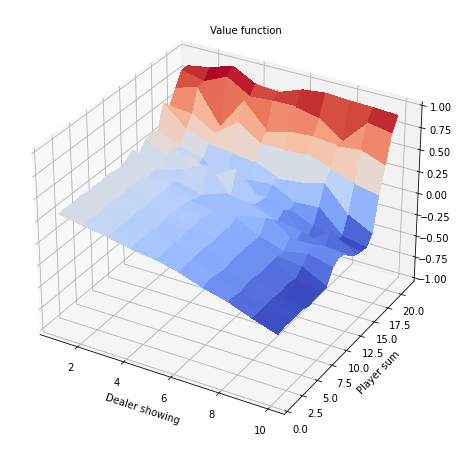

In [8]:
df_V = mc_agent.get_V()

plot_value_function(df_V)

In [9]:
# animate(checkpoints, "Easy21_MC_control")

![Value function surface plot](../animations/Easy21_MC_control.gif)

## 3 - TD Learning in Easy21

In [10]:
n_episodes = 100000
n_checkpoints = 20

episodes_per_checkpoint = round(n_episodes / n_checkpoints)
rewards = deque(maxlen=episodes_per_checkpoint)

checkpoint = namedtuple("checkpoint", ("i", "mean_reward", "V"))

In [11]:
checkpoints = []

env = EasyEnvironment()

td_agent = TDAgent(
    policy=EpsilonGreedyPolicy(N_zero=100),
    lmbda=0.1
)

t_start = perf_counter()

for i in range(n_episodes):

    # Checkpoint: print progress and store value function
    if i % episodes_per_checkpoint == 0:

        time_elapsed =  perf_counter() - t_start
        mean_reward = np.array(rewards).mean() if rewards else 0
        print_progress(i, n_episodes, time_elapsed, mean_reward)
        t_start = perf_counter()

        if i > 1:
            checkpoints.append(checkpoint(i, mean_reward, td_agent.get_V()))

    # Reset environment and agent
    env.reset()
    td_agent.reset_episode()

    s = env.get_state()
    a = td_agent.step(s)

    while not s.terminal:

        # Take step, first environment using action, then agent using next state
        next_s, R = env.step(a)

        # Optimize Q
        a = td_agent.optimize([Transition(s, a, next_s, R)])

        # Set state, action to next state, next action
        s = copy(next_s)

        # Append reward
        rewards.append(R)

Episode:          0/100000 ---   0.0 --- mean reward:  0.00 --- elapsed:  0.0 seconds
Episode:       5000/100000 ---   5.0 --- mean reward: -0.06 --- elapsed:  1.7 seconds
Episode:      10000/100000 ---  10.0 --- mean reward: -0.03 --- elapsed:  1.6 seconds
Episode:      15000/100000 ---  15.0 --- mean reward: -0.01 --- elapsed:  1.5 seconds
Episode:      20000/100000 ---  20.0 --- mean reward: -0.02 --- elapsed:  1.5 seconds
Episode:      25000/100000 ---  25.0 --- mean reward:  0.01 --- elapsed:  1.5 seconds
Episode:      30000/100000 ---  30.0 --- mean reward: -0.00 --- elapsed:  1.5 seconds
Episode:      35000/100000 ---  35.0 --- mean reward:  0.03 --- elapsed:  1.5 seconds
Episode:      40000/100000 ---  40.0 --- mean reward:  0.01 --- elapsed:  1.5 seconds
Episode:      45000/100000 ---  45.0 --- mean reward:  0.02 --- elapsed:  1.5 seconds
Episode:      50000/100000 ---  50.0 --- mean reward:  0.02 --- elapsed:  1.5 seconds
Episode:      55000/100000 ---  55.0 --- mean reward: 

(<mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x11d07e7f0>,
 Text(2, 21, 'Value function'))

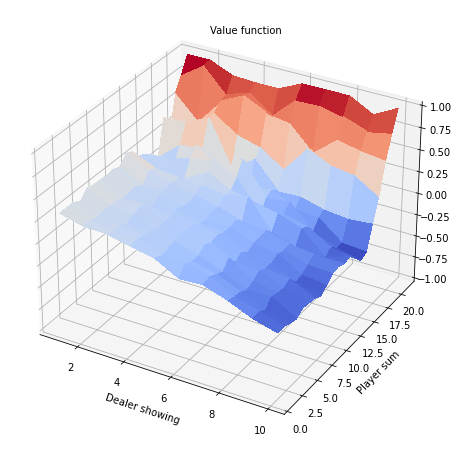

In [12]:
df_V = td_agent.get_V()

plot_value_function(df_V)

In [13]:
# animate(checkpoints, "Easy21_TD_control")

![Value function surface plot](../animations/Easy21_TD_control.gif)

### Evaluating different lambdas

In [14]:
def calc_sse(agent):
    
    sse = 0
    for key, q_mc in mc_agent.Q.r.items():
        q = agent.Q(key)
        sse += (q_mc - q) ** 2
        
    return sse

def train_lambda(lmbda, n_episodes=1000):
    
    env = EasyEnvironment()

    td_agent = TDAgent(
        policy=EpsilonGreedyPolicy(N_zero=100),
        lmbda=lmbda
    )
        
    sse_curve = np.zeros(n_episodes)

    for i in range(n_episodes):

        # Reset environment and agent
        env.reset()
        td_agent.reset_episode()

        s = env.get_state()
        a = td_agent.step(s)

        while not s.terminal:

            # Take step, first environment using action, then agent using next state
            next_s, R = env.step(a)

            # Optimize Q
            a = td_agent.optimize([Transition(s, a, next_s, R)])

            # Set state, action to next state, next action
            s = copy(next_s)
            
        sse_curve[i] = calc_sse(td_agent)
            
    return sse_curve

def grid_search_lambdas(lambdas, n_episodes, n_eval):
    
    # Run simulation
    
    f = partial(train_lambda, n_episodes=n_episodes)
    
    lambda_sse_curves = []

    for lmbda in lambdas:
        print(f"Starting lambda: {lmbda:.1f}")

        # Do n_eval repetitions and take the mean to take the noise out
        sse_curves_eval = Parallel(n_jobs=12)(delayed(f)(lmbda) for _ in range(n_eval))
            
        sse_curve = np.r_[sse_curves_eval].mean(axis=0)
        lambda_sse_curves.append((lmbda, sse_curve))
        
    return lambda_sse_curves

def plot_grid_search_results(lambda_sse_curves):
        
    # Plot lambdas vs SSE
    
    lambda_sses = [(l, sse_curve[-1]) for l, sse_curve in lambda_sse_curves]

    X = np.array(lambda_sses)[:,0]
    Y = np.array(lambda_sses)[:,1]

    plt.plot(X, Y)
    plt.xlabel("lambda")
    plt.ylabel("SSE")
    plt.show()
    
    # Plot episode vs SSE for lambda = 0 and lambda = 1
    
    plt.plot(lambda_sse_curves[0][1], label=f"lambda={lambda_sse_curves[0][0]}")
    plt.plot(lambda_sse_curves[-1][1], label=f"lambda={lambda_sse_curves[-1][0]}")
    plt.xlabel("episode")
    plt.ylabel("SSE")
    plt.legend(loc="lower right")
    plt.show()
    
    # Plot episode vs SSE for different lambdas
    
    for lmbda in [0, 0.1, 0.5, 0.8, 0.9, 1]:
        for lsc in lambda_sse_curves:
            if lsc[0] == lmbda:
                plt.plot(lsc[1], label=f"lambda={lsc[0]}")
    plt.xlabel("episode")
    plt.ylabel("SSE")
    plt.legend(loc="lower right")
    plt.show()

### For n_episodes = 1.000

Starting lambda: 0.0
Starting lambda: 0.1
Starting lambda: 0.2
Starting lambda: 0.3
Starting lambda: 0.4
Starting lambda: 0.5
Starting lambda: 0.6
Starting lambda: 0.7
Starting lambda: 0.8
Starting lambda: 0.9
Starting lambda: 1.0


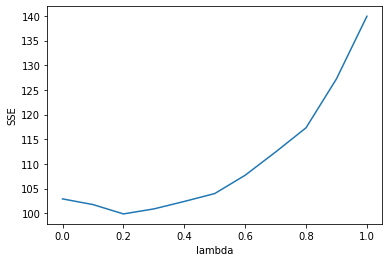

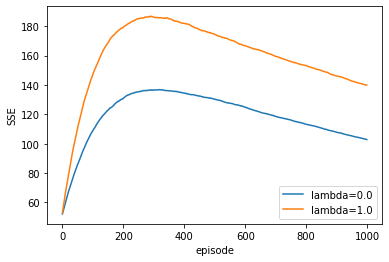

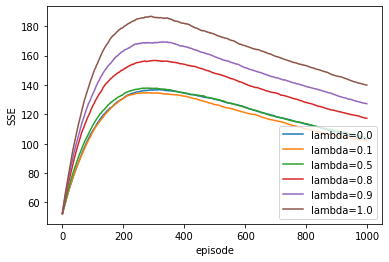

In [15]:
lambdas = np.arange(0, 1.1, 0.1)

lambda_sse_curves = grid_search_lambdas(lambdas, n_episodes=1000, n_eval=100)

plot_grid_search_results(lambda_sse_curves)

### For n_episodes = 10.000

Starting lambda: 0.0
Starting lambda: 0.1
Starting lambda: 0.2
Starting lambda: 0.3
Starting lambda: 0.4
Starting lambda: 0.5
Starting lambda: 0.6
Starting lambda: 0.7
Starting lambda: 0.8
Starting lambda: 0.9
Starting lambda: 1.0


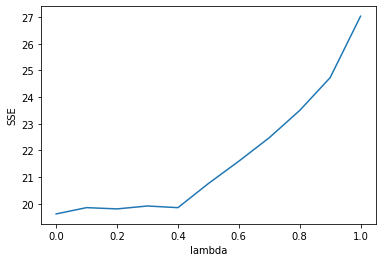

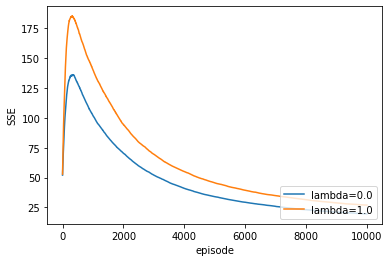

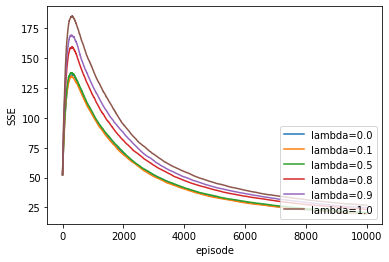

In [16]:
lambdas = np.arange(0, 1.1, 0.1)

lambda_sse_curves = grid_search_lambdas(lambdas, n_episodes=10000, n_eval=100)

plot_grid_search_results(lambda_sse_curves)